In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import sciann as sn
from sciann import math as snm
import keras

Using TensorFlow backend.


---------------------- SCIANN 0.4.6.2 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 



In [3]:
import sys
sys.path.append('../../')
import src
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import src.plot_utils as plot_utils
import src.ml_utils as ml_utils
import src.eikonal as eikonal
from src.openst import OpenST as ost
from tqdm.notebook import tqdm
import datetime
import pickle

In [4]:
def save(obj, filename, mode='wb'):
    with open(filename, mode) as f:
        pickle.dump(obj, f)
        
def load(filename, mode='rb'):
    with open(filename, mode) as f:
        d = pickle.load(f)
    return d

In [238]:
def eikonal_ann(nu=50, nl=4, act='tanh', optimizer='adam', targets=['T', 'E', 'M']):
    # Inputs
    x = sn.Variable('x')
    z = sn.Variable('z')

    # Traveltime
    T = sn.Functional('Traveltime', [x, z], [nu]*nl, act)

    # Eikonal
    Tx = snm.diff(T, x)
    Tz = snm.diff(T, z)
    Tr2 = Tx**2 + Tz**2
    E = sn.Data(Tr2)
    
    # Gradient Field
    F = [Tx, Tz]
    
    # Monotonicity
    Tr = snm.sqrt(Tr2) + 1e-16
    r = snm.sqrt(x**2 + z**2) + 1e-16
    scal = Tx * x + Tz * z
    M = scal / r / Tr
    M = snm.relu(-M)
    M = sn.Data(M)
    
    # Model and outputs
    outs = {'T': T, 'E': E, 'M': M, 'F': F}
    trgs = []
    for t in targets:
        trgs.append(outs[t])
    model = sn.SciModel([x, z], trgs, optimizer=optimizer)
    model.model.output_names = targets
    return model, outs

In [205]:
def eikonal_ann2(nu=50, nl=4, act='tanh', optimizer='adam', targets=['T', 'E', 'M']):
    # Inputs
    x = sn.Variable('x')
    z = sn.Variable('z')

    # Traveltime
    T = sn.Functional('Traveltime', [x, z], [nu]*nl, act)

    # Eikonal
    Tx = snm.diff(T, x)
    Tz = snm.diff(T, z)
    Tr2 = Tx**2 + Tz**2
    E = sn.Data(snm.sqrt(Tr2))

    # Monotonicity
    Tr = snm.sqrt(Tr2) + 1e-16
    r = snm.sqrt(x**2 + z**2) + 1e-16
    scal = Tx * x + Tz * z
    M = scal / r / Tr
    M = snm.relu(-M)
    M = sn.Data(M)
    
    # Model and outputs
    outs = {'T': T, 'E': E, 'M': M}
    trgs = []
    for t in targets:
        trgs.append(outs[t])
    model = sn.SciModel([x, z], trgs, optimizer=optimizer)
    model.model.output_names = targets
    return model, outs

In [ ]:
def eikonal_ann_inv(nu=50, nl=4, act='tanh', optimizer='adam'):
    # Inputs
    x = sn.Variable('x')
    z = sn.Variable('z')

    # Traveltime
    T = sn.Functional('Traveltime', [x, z], [nu]*nl, act)

    # Eikonal
    Tx = snm.diff(T, x)
    Tz = snm.diff(T, z)
    Tr2 = Tx**2 + Tz**2
    E = Tr2
    
    
    # Positivity
#     P = snm.relu(-T)

    # Laplacian
#     Txx, Tzz = snm.diff(Tx, x), snm.diff(Tz, z)
#     L = Txx + Tzz
#     L = snm.abs(L)
    
    # Model and outputs
    targets = [T, E]
    names = ['T', 'E', 'P']
    model = sn.SciModel([x, z], [T, E], optimizer=optimizer)
    outs = {n:v for n, v in zip(names, targets)}
    return model, outs

[SEG model](#seg)

<a id="up"></a>

# Regular grid

In [5]:
nx, nz = 51, 51
xmin, xmax = 0.0, 2000.0
zmin, zmax = 0.0, 2000.0
frames = np.array([xmin, xmax, zmin, zmax])
scaler = max(abs(frames))

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)

dx, dz = x[1] - x[0], z[1] - z[0]
XZ = np.array(np.meshgrid(x, z, indexing='ij'))
X, Z = XZ

In [7]:
# Velocity
vmin, vmax = 1000.0, 1000.1
a = (vmax - vmin) / zmax
V = eikonal.vel_func(vmin, a)(Z)
V_scaled = V / vmax

# Source
ixs, izs = nx//2, nz//2
sid = (ixs, izs)
rav_sid = np.ravel_multi_index(sid, (nx, nz))
xs, zs = X[ixs, izs], Z[ixs, izs]
sou = [xs, zs]
sou_xz = np.array(sou, ndmin=2)

# Grid
X_shift, Z_shift = X - xs, Z - zs
X_scaled, Z_scaled = X_shift / scaler, Z_shift / scaler
X_scaled_inv, Z_scaled_inv = X / scaler, Z / scaler

# Solution
T = eikonal.t_vgrad(X, Z, xs, zs, vmin, a)
T_scaled = T * vmax / scaler

# Indices for additinal bounds
new_inds = np.array([(ixs - 1, izs), (ixs + 1, izs), (ixs, izs - 1), (ixs, izs + 1)])
inds = np.vstack((new_inds, [[ixs, izs]]))
rav_inds = np.ravel_multi_index(inds.T, (nx, nz))

# Gradient
tau_grad = eikonal.t_vfield_vgrad(X, Z, xs, zs, vmin, a)
# tau_modul = np.linalg.norm(tau_grad, axis=-1, keepdims=True) + 1e-16
# tau_grad /= tau_modul

../..\src\eikonal\helpers.py:87: RuntimeWarning: divide by zero encountered in true_divide
  A = 1 / a / np.sqrt((up / down + 1)**2 - 1)
../..\src\eikonal\helpers.py:88: RuntimeWarning: invalid value encountered in multiply
  dt_dx = 2 * a**2 * Xdiff / down * A
../..\src\eikonal\helpers.py:89: RuntimeWarning: invalid value encountered in multiply
  dt_dz = (2 * a**2 * Zdiff / down - 2 * a * Vxszs * up / down**2) * A


In [25]:
ixs, izs = 25, 25
Vhomo = np.full_like(X, 1000.0)
R = np.sqrt((X - x[ixs])**2 + (Z - z[izs])**2)
Thomo = R / Vhomo

dx, dz = x[1] - x[0], z[1] - z[0]
XZ_step = np.array([dx, dz])
XZ_min = np.array([xmin, zmin])
XZ_max = np.array([xmax, zmax])

Tfsm = ost.LSM2D(Vhomo, XZ_min, XZ_max, XZ_step, [x[ixs], z[izs]])

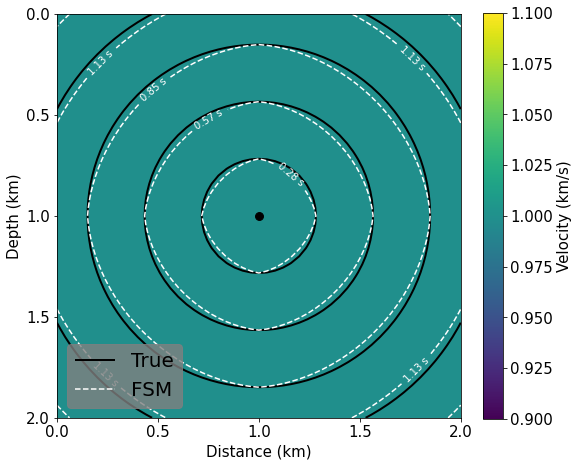

In [35]:
extent1 = np.array((xmin, xmax, zmax, zmin)) / 1000
extent2 = np.array((xmin, xmax, zmin, zmax)) / 1000

plt.rcParams['font.size'] = 15

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

im = ax.imshow(Vhomo.T / 1000, extent=extent1)

levels = np.linspace(0, Thomo.max(), 6)
ctr1 = ax.contour(Thomo.T, levels=levels, colors='k', linestyles='-', linewidths=2, extent=extent2)
ctr2 = ax.contour(Tfsm.T, levels=levels, colors='w', linestyles='--', linewidths=1.5, extent=extent2)
plt.clabel(ctr2, levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)

ax.scatter(ixs * dx / 1000, izs * dz / 1000, marker='.', s=250, color='k')
# ax.scatter(rest_sid[0] * dx / 1000, rest_sid[1] * dz / 1000, marker='.', s=100, color='w')

# ax.scatter(X[bounds[0]] / 1000, X[bounds[1]] / 1000, marker='s', s=70, color='r')

plt.axis('scaled')
# plt.ylim([zmax, zmin])
plt.colorbar(mappable=im, ax=ax, fraction=1/22, label='Velocity (km/s)')
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (km)')
ax.set_xticks(np.linspace(0, 2, 5))
ax.set_yticks(np.linspace(0, 2, 5))

h1,_ = ctr1.legend_elements()
h2,_ = ctr2.legend_elements()
ax.legend([h1[0], h2[0]], ['True', 'FSM'], loc='lower left', fontsize=20, facecolor='grey', edgecolor='grey')

plt.show()

In [38]:
print(abs(Thomo - Tfsm).sum() / Thomo.sum() * 100,
np.pi)

3.1456145571205694 3.141592653589793


# Random grid

In [ ]:
sigm_x = max(abs(x - xs)) / 4
sigm_z = max(abs(z - zs)) / 4
cov = np.diag([sigm_x**2, sigm_z**2])
XZ_r = np.random.multivariate_normal(sou, cov, 5000)
XZ_r = np.vstack([XZ_r, XZ.reshape(2, -1).T])
X_r, Z_r = XZ_r.T
XZ_r = XZ_r[(X_r < xmax) * (X_r > xmin) * (Z_r < zmax) * (Z_r > zmin)]
XZ_r = np.concatenate((XZ_r, sou_xz), axis=0)
X_r, Z_r = XZ_r.T
XZ_r_shift = XZ_r - sou_xz
X_r_shift, Z_r_shift = XZ_r_shift.T
X_r_scaled, Z_r_scaled = X_r_shift / scaler, Z_r_shift / scaler

V_r = eikonal.vel_func(vmin, a)(Z_r)
V_r_scaled = V_r / vmax

R_r = np.linalg.norm(np.stack([X_r_shift, Z_r_shift], axis=-1), axis=-1)
T_r = eikonal.t_vgrad(X_r, Z_r, xs, zs, vmin, a)

rb_ids = np.argwhere(T_r == 0.0).squeeze()
req_ids = np.argwhere(T_r > 0.0).squeeze()

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(X_r, Z_r, c=T_r, s=5)
plt.axis('scaled')
plt.xlim([xmin, xmax])
plt.ylim([zmax, zmin])
plt.show()

In [ ]:
# Indices except SOURCE POINT for Eikonal, Monotonicity, Laplace etc
eq_ids = np.arange(0, nx*nz, 1, dtype=int)
eq_ids = eq_ids[eq_ids != rav_sid]
# b_ids = np.array([rav_sid])
b_ids = np.arange(0, nx*nz, 1, dtype=int)

# b_ids = np.argwhere(Z.ravel() == 0).squeeze()
# b_ids = np.hstack((b_ids, np.argwhere(X.ravel() == 0).squeeze()))
# b_ids = np.hstack((b_ids, np.argwhere(X.ravel() == xmax).squeeze()))

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(V.T)
ctr = plt.contour(T.T, colors='r', linestyles='--')
plt.axis('scaled')
plt.ylim([nz-1, 0])
plt.show()

In [ ]:
x_data = X_scaled.ravel().copy()
z_data = Z_scaled.ravel().copy()
v_data = V_scaled.ravel().copy()
s_data = 1 / v_data
t_true = np.zeros_like(x_data)
t_true[b_ids] = T_scaled.ravel()[b_ids]

# rx_data = X_r_scaled.ravel()
# rz_data = Z_r_scaled.ravel()
# rv_data = V_r_scaled.ravel()
# rs_data = 1 / rv_data
# rt_true = (T_r * vmax / scaler).ravel()

In [18]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3, decay=1e-4)

In [ ]:
model, outs = eikonal_ann(nu=50, nl=4, act='tanh', optimizer=optimizer)

In [22]:
MODELS, OUTS, HISTORIES, LOSSES = [], [], [], []

train_kw = dict(x_true = [x_data, z_data],
                y_true = [(b_ids, t_true), s_data**2, 'zero'], 
                target_weights = [3.0, 1.0, 3.0],
                epochs=15000, verbose=0, 
                batch_size=len(t_true),
#                 learning_rate=([1500, 3000, 5000, 7000, 8500], 
#                                [2.5e-4, 1e-4, 5e-5, 1e-5, 1e-6]),
                callbacks=[]
               )

In [23]:
model.model.compile(optimizer, 'mse')

In [24]:
path = '../../data/eikonal/Stability9/'
for i in tqdm(range(0, 10)):
    model, outs = eikonal_ann(act='tanh', optimizer=optimizer)
    print(i)
    h = model.train(**train_kw)
    model.save_weights(path+'weights_'+str(i))
    MODELS.append(model)
    OUTS.append(outs)
    HISTORIES.append(h.history)
    l = np.array(list(h.history.values()))
    print(np.round(l[:-1,-1], 5))
    LOSSES.append(l[0,-1])

0
[0.00407 0.00295 0.00111]
1
[0.00387 0.00281 0.00105]
2
[0.01003 0.00205 0.00795]
3
[0.00493 0.00234 0.00255]
4
[0.00709 0.00481 0.00227]
5
[0.00428 0.00239 0.00189]
6
[0.01343 0.00072 0.01271]
7
[0.00468 0.00202 0.00266]
8
[0.00774 0.00379 0.00395]
9
[0.01439 0.01201 0.00238]



In [ ]:
save(train_kw, path + 'train_kw')
save(HISTORIES, path + 'histories')
save(LOSSES, path + 'losses')

<hr>

In [249]:
E_ids = np.arange(0, nx*nz, 1, dtype=int)
E_ids = eq_ids[eq_ids != rav_sid]
M_ids = E_ids.copy()
T_ids = np.array([rav_sid])
# b_ids = np.arange(0, nx*nz, 1, dtype=int)

x_data = X_scaled.ravel().copy()
z_data = Z_scaled.ravel().copy()
v_data = V_scaled.ravel().copy()
s_data = 1 / v_data
t_true = np.zeros_like(x_data)
# t_true[b_ids] = T_scaled.ravel()[b_ids]

In [219]:
def getSampleWeights(out, x, true, wmin=0.1, wmax=0.9):
    pred = out.eval(x).ravel()
    w = np.abs(pred - true) / true
    w[w < wmin] = wmin
    w[w > wmax] = wmax
    return w

def SampleWeights(X, Z, mu, sigma, wmin=0.0, wmax=1.0):
    e = np.exp(-(X - mu[0])**2 / 2 / sigma**2 - (Z - mu[1])**2 / 2 / sigma**2)
    w = (wmax - wmin) * e / e.max() + wmin
    return w

In [333]:
from tqdm.notebook import tqdm

def update_ids(E_loss, M_loss, tol, sid):
    ids = np.arange(0, len(E_loss), 1, dtype=int)
    ids = ids[ids != sid]
    cond = (E_loss < tol) & (M_loss == 0.0)
    cond[sid] = True
    T_ids = np.argwhere(cond).squeeze()
    T_ids = np.concatenate((T_ids, np.array([sid])))
    E_ids = np.argwhere(cond == False).squeeze()
    return T_ids, E_ids, ids, cond

def loss_MSE(true, pred):
    return (true - pred)**2

def loss_MAE(true, pred):
    return np.abs(true - pred)

def trainer(model, outs, true, train_kw, iters, sid, loss_func=loss_MAE, tol=1e-4):
    x = train_kw['x_true']
    ids = np.arange(0, len(x[0]), 1, dtype=int)
    ids = ids[ids != sid]
    T_ids, E_ids, M_ids = np.array([sid]), ids, ids
    train_kw['y_true'] = [(T_ids, 'zero'), (E_ids, true.copy()), (M_ids, 'zero')]
    IDS = {'T': [T_ids], 'E': [E_ids], 'M': [M_ids]}
    for i in tqdm(range(iters)):
        model.train(**train_kw)
        pred = outs['E'].eval(x).ravel()
        E_loss = np.abs(true - pred)
        M_loss = outs['M'].eval(x).ravel()
        T = outs['T'].eval(x).ravel()
        T[sid] = 0.0
        T_ids, E_ids, M_ids, cond = update_ids(E_loss, M_loss, tol, sid)
        train_kw['y_true'] = [(T_ids, T), (E_ids, true.copy()), (M_ids, 'zero')]
        IDS['T'].append(T_ids)
        IDS['E'].append(E_ids)
        IDS['M'].append(M_ids)
        print(len(T_ids), E_loss.mean())
    return IDS

In [327]:
train_kw = dict(x_true = [x_data, z_data],
#                 y_true = [(T_ids, t_true), (E_ids, s_data.copy()), (M_ids, 'zero')],
                target_weights = [3.0, 1.0, 3.0],
                epochs=1500, verbose=0, 
                batch_size=len(x_data),
                callbacks=[]
               )

In [336]:
model, outs = eikonal_ann(nu=50, nl=4, act='tanh', targets=['T', 'E', 'M'])

In [337]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3, decay=1e-4)
model.model.compile(optimizer, 'mse')

In [338]:
h = trainer(model, outs, s_data**2, train_kw, iters=10, sid=rav_sid, loss_func=MAE, tol=1e-4)

6 0.10943934072242548
4 0.08569306393405204
9 0.037412452962994655
10 0.025329031691018182
16 0.023598346408864546
9 0.0318644610015935
10 0.02353117336798615
12 0.0291485124587218
12 0.011842540785768853
19 0.01130711062779021



In [ ]:
%%time
w = SampleWeights(X, Z, [x[ixs], z[izs]], 250.0)
train_kw['weights'] = w.ravel()
h = model.train(**train_kw)

In [339]:
pred = outs['T'].eval([x_data, z_data]).reshape(nx,nz) / vmax * scaler 
rest_rav_sid = np.argmin(pred)
rest_sid = np.unravel_index(rest_rav_sid, (nx, nz))
bounds = np.unravel_index(b_ids, (nx,nz))

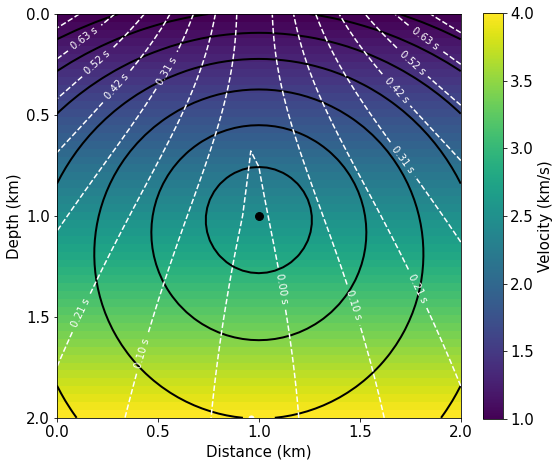

In [340]:
extent1 = np.array((xmin, xmax, zmax, zmin)) / 1000
extent2 = np.array((xmin, xmax, zmin, zmax)) / 1000

plt.rcParams['font.size'] = 15

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

im = ax.imshow(V.T / 1000, extent=extent1)

levels = np.linspace(0, T.max(), 9)
ctr1 = ax.contour(T.T, levels=levels, colors='k', linestyles='-', linewidths=2, extent=extent2)
ctr2 = ax.contour(pred.T, levels=levels, colors='w', linestyles='--', linewidths=1.5, extent=extent2)
plt.clabel(ctr2, levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)

ax.scatter(ixs * dx / 1000, izs * dz / 1000, marker='.', s=250, color='k')
ax.scatter(rest_sid[0] * dx / 1000, rest_sid[1] * dz / 1000, marker='.', s=100, color='w')

# ax.scatter(X[bounds[0]] / 1000, X[bounds[1]] / 1000, marker='s', s=70, color='r')

plt.axis('scaled')
# plt.ylim([zmax, zmin])
plt.colorbar(mappable=im, ax=ax, fraction=1/22, label='Velocity (km/s)')
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (km)')
ax.set_xticks(np.linspace(0, 2, 5))
ax.set_yticks(np.linspace(0, 2, 5))

plt.show()

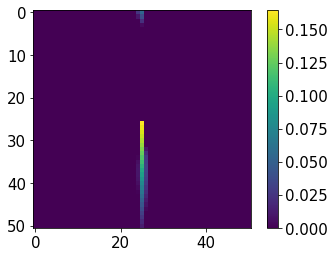

In [341]:
plt.imshow(outs['M'].eval([x_data, z_data]).reshape(nx,nz).T)
plt.colorbar()

In [312]:
MAE = np.abs(T - pred)
rMAE = MAE / T * 100
rMAE[ixs, izs] = MAE[ixs, izs]
print(MAE.mean(), ' or ', rMAE.mean(), ' %')

0.11837274206327286  or  40.553813772737826  %


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [313]:
E = outs['E'].eval([x_data, z_data]).reshape(nx,nz)
Ve = np.sqrt(1 / E) * vmax
Ve[ixs,izs] = np.nan
Vd = np.abs(V - Ve)
Vd[ixs, izs] = np.nan

In [314]:
np.nanmean(Vd)

8.619901662973257

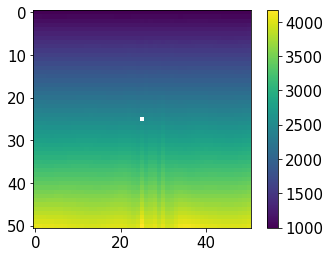

In [315]:
plt.imshow(Ve.T)
plt.colorbar()

<hr>

In [ ]:
path = '../../data/eikonal/Stability'

In [ ]:
N = 9
PREDS = np.empty((N, 10, nx, nz))
MAE = np.empty((N, 10, nx, nz))
mMAE = np.empty((N, 10))
TRAIN_KW = []
HIST = []
for i in tqdm(range(N)):
    model, outs = eikonal_ann(act='tanh'*(i<8) + 'relu'*(i==8))
    TRAIN_KW.append(load(path + str(i) + '/train_kw'))
    HIST.append(load(path + str(i) + '/histories'))
    for j in range(10):
        model.load_weights(path + str(i) + '/weights_' + str(j))
        t_pred = outs['T'].eval([x_data, z_data]).reshape(nx, nz) / vmax * scaler
        t_pred -= t_pred[ixs, izs]
        err = np.abs(t_pred - T)
        MAE[i,j] = err.reshape(nx,nz)
        mMAE[i,j] = np.mean(MAE[i,j])
        PREDS[i,j] = t_pred.reshape(nx,nz)

In [ ]:
sort_ind = np.argsort(mMAE, axis=-1)
minmidmax = sort_ind[:, [0, 4, -1]]

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=N, sharex='col', sharey='row', figsize=(15, 35))

for (i,j), ax in np.ndenumerate(axes):
    im = ax.contourf(PREDS[i,minmidmax[i,j]].T)
    name = ['BEST\n\n', 'MIDDLE\n\n', 'WORST\n\n']
    ax.set_title(name[j]*(i==0) + 'mae = {0:.3f}, loss = {1:.3f}'.format(mMAE[i,minmidmax[i,j]], 
                                                                         HIST[i][minmidmax[i,j]]['loss'][-1]),
                 fontsize=15)
    if j == 0:
        ax.set_ylabel('WEIGHTS\n\n' + str(TRAIN_KW[i]['target_weights']), fontsize=15)
    ax.set_ylim([nz-1, 0])
    ax.axis('scaled')
    plt.colorbar(mappable=im, ax=ax)

plt.show()

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=N, sharex='col', sharey='row', figsize=(15, 20))

for (i,j), ax in np.ndenumerate(axes):
    for k, v in HIST[i][minmidmax[i,j]].items():
        if k != 'lr' and k != 'Traveltime_loss':
            ax.plot(np.log10(v), label=k)
    ax.set_title('mae = {0:.3f}'.format(mMAE[i,minmidmax[i,j]]))
    j += 1
axes[0,0].legend(loc='lower left')
plt.show()

<hr>

<a id="seg"></a>

# SEG model

[Up](#up)

In [ ]:
def prepare_inputs(x, z, V, T, ixs, izs):
    nx, nz = V.shape
    
    xmin, xmax = x.min(), x.max()
    zmin, zmax = z.min(), z.max()
    vmax = V.max()
    
    xzmax = max(abs(np.array([xmin, xmax, zmin, zmax])))

    XZ = np.meshgrid(x, z, indexing='ij')
    X, Z = XZ
    X_s = X - x[ixs]
    Z_s = Z - z[izs]
    
    pure = (X, Z, V, T)
    scaled = (X_s.ravel() / xzmax, Z_s.ravel() / xzmax, 
              V.ravel() / vmax, T.ravel() / xzmax * vmax)
    scalers = (xzmax, vmax)
    
    rav_sid = np.ravel_multi_index((ixs, izs), (nx, nz))
    eq_ids = np.arange(0, nx*nz, 1, dtype=int)
    eq_ids = eq_ids[eq_ids != rav_sid]
    b_ids = np.array([rav_sid])
    indices = (b_ids, eq_ids)
    
    return pure, scaled, scalers, indices

In [ ]:
V_ = np.load('../../data/segModel.npy')

In [ ]:
sp = 2
V = V_[::sp, ::sp]

nx, nz = V.shape
xmin, xmax = 0.0, 2000.0
zmin, zmax = 0.0, 2000.0

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)

dx, dz = x[1] - x[0], z[1] - z[0]
XZ_step = np.array([dx, dz])
XZ_min = np.array([xmin, zmin])
XZ_max = np.array([xmax, zmax])

In [ ]:
ixs, izs = int(nx / 2), int(nz / 2)

T = ost.LSM2D(V, XZ_min, XZ_max, XZ_step, [x[ixs], z[izs]])

In [ ]:
extent = (0, nx-1, nz-1, 0)

plt.figure(figsize=(6,6))
plt.imshow(V.T, extent=extent)
ctr = plt.contour(T.T, colors='r', linestyles='--')
plt.axis('scaled')
plt.ylim([nz-1, 0])
plt.show()

In [ ]:
pure, scaled, scalers, indices = prepare_inputs(x, z, V, T, ixs, izs)

In [ ]:
xzmax, vmax = scalers
x_data, z_data, v_data, t_data = scaled
s_data = 1 / v_data
b_ids, eq_ids = indices
s_data[b_ids] = 0.0

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=2e-3, decay=1e-4)
train_kw = dict(x_true = [x_data, z_data],
                y_true = [(b_ids, 'zero'), s_data**2, 'zero'], 
                target_weights = [3.0, 1.0, 3.0],
                epochs=200, verbose=1, 
                batch_size=len(x_data),
                callbacks=[],
                weights=np.ones((len(x_data), 1))
               )

In [ ]:
model, outs = eikonal_ann(nu=50, nl=4, act='tanh', optimizer=optimizer)

In [ ]:
def getSampleWeights(out, train_kw, wmin=0.1, wmax=0.9):
    pred = out.eval(train_kw['x_true']).ravel()
    true = train_kw['y_true'][1].ravel()
    w = np.abs(pred - true) / true
    w[w < wmin] = wmin
    w[w > wmax] = wmax
    return w

def fromCoarseToFine(sp, epochs, x_data, z_data, s_data, b_ids, weights=None):
    s_data[b_ids] = 0.0
    x_d, z_d, s_d = x_data[::sp], z_data[::sp], s_data[::sp]
    bi_ids = np.argwhere(s_d == 0.0).squeeze()
    B_ids = np.hstack((bi_ids, [len(x_d)]))
    x_d = np.hstack((x_d, x_data[b_ids]))
    z_d = np.hstack((z_d, z_data[b_ids]))
    s_d = np.hstack((s_d, s_data[b_ids]))
    train_kw = dict(x_true = [x_d, z_d],
                y_true = [(B_ids, 'zero'), s_d**2, 'zero'], 
                target_weights = [3.0, 1.0, 3.0],
                epochs=epochs, verbose=1, 
                batch_size=len(x_d),
                callbacks=[],
                weights=weights
               )
    return train_kw

In [ ]:
%%time
sp = np.arange(100, 1, -4)
w = None
for spi in sp:
    train_kw = fromCoarseToFine(spi, 500, x_data, z_data, s_data, b_ids, w)
    model.train(**train_kw)
#     w = getSampleWeights(outs['E'], train_kw)[..., None]

In [ ]:
model.train(**train_kw)

In [ ]:
model.save_weights('../../data/eikonal/weightsForward')

In [ ]:
model.load_weights('../../data/eikonal/weightsForward')

In [ ]:
pred = outs['T'].eval([x_data, z_data]).reshape(nx,nz) * xzmax / vmax
pred -= pred.min()

In [ ]:
extent1 = np.array((xmin, xmax, zmax, zmin)) / 1000
extent2 = np.array((xmin, xmax, zmin, zmax)) / 1000

plt.rcParams['font.size'] = 15

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

im = ax.imshow(V.T / 1000, extent=extent1)

levels = np.linspace(0, T.max(), 9)
ctr1 = ax.contour(T.T, levels=levels, colors='k', linestyles='-', linewidths=2, extent=extent2)
ctr2 = ax.contour(pred.T, levels=levels, colors='w', linestyles='--', linewidths=1.5, extent=extent2)
plt.clabel(ctr2, levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)

ax.scatter(ixs * dx / 1000, izs * dz / 1000, marker='o', s=45, color='r', label='source')

ax.axis('scaled')
# plt.ylim([zmax, zmin])
plt.colorbar(mappable=im, ax=ax, fraction=1/22, label='Velocity (km/s)')
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (km)')
ax.set_xticks(np.linspace(0, 2, 5))
ax.set_yticks(np.linspace(0, 2, 5))
ax.legend(loc='lower left')

plt.show()

In [ ]:
MAE = np.abs(T - pred)
rMAE = MAE / T * 100
rMAE[ixs, izs] = MAE[ixs, izs]
MAE.mean()

In [ ]:
E = outs['E'].eval([x_data, z_data]).reshape(nx,nz)
Ve = np.sqrt(1 / E) * vmax
Ve[ixs,izs] = np.nan
Vd = np.abs(V - Ve)
Vd[ixs, izs] = np.nan

In [ ]:
np.nanmean(Vd / V) * 100

In [ ]:
grad_T = np.array(np.gradient(T, x, z, ))
Vfsm = 1 / np.linalg.norm(grad_T, axis=0)
Vfsm[ixs, izs] = np.nan
Vfsmd = np.abs(Vfsm - V)
Vfsmd[ixs, izs] = np.nan

In [ ]:
np.nanmean(Vfsmd / V) * 100

In [ ]:
desc = 'MAE = {0:.2f} m/s'.format

plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(Ve.T)
plt.colorbar()

plt.subplot(222)
plt.title(desc(np.nanmean(Vd)))
plt.imshow(Vd.T)
plt.colorbar()

plt.subplot(223)
plt.imshow(Vfsm.T)
plt.colorbar()

plt.subplot(224)
plt.title(desc(np.nanmean(Vfsmd)))
plt.imshow(Vfsmd.T)
plt.colorbar()

plt.show()

In [ ]:
grad_T.shape